In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

'''알고리즘 관련 라이브러리'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import hdbscan

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.
C:\Users\EunHye\anaconda3\envs\unsupervisedLearning\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\EunHye\anaconda3\envs\unsupervisedLearning\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\EunHye\anaconda3\envs\unsupervisedLearning\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', 'UCR_TS_Archive_2015', ''])

data_train = np.loadtxt(current_path+file+"ECGFiveDays/ECGFiveDays_TRAIN", delimiter=",")
X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)

data_test = np.loadtxt(current_path+file+"ECGFiveDays/ECGFiveDays_TEST", delimiter=",")
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [3]:
# 기본 요약 통계
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [4]:
# 훈련 셋에서 각 클래스별 샘플 수
print("Number of time series in class 1.0:", len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", len(data_train[data_train[:,0]==2.0]))

Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


Plot  0  Class  1.0


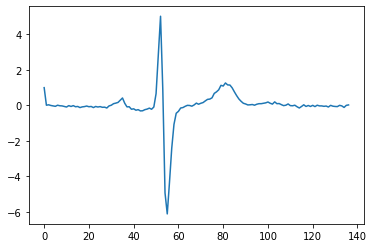

Plot  1  Class  1.0


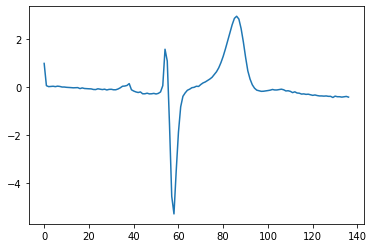

In [5]:
# 클래스 1.0 인 샘플
for i in range(0,2):
    if data_train[i,0]==1.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

In [6]:
df = pd.DataFrame({'x':[1,2,3]})

np.array(df['x']).reshape(-1,1)

array([[1],
       [2],
       [3]], dtype=int64)

In [7]:
# 데이터 준비 - 스케일
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [8]:
# k-Shape를 사용한 훈련
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(n_clusters=2, n_init=100, verbose=0)

In [9]:
# 훈련 셋의 예측값 생성 및 수정된 Rand 지수 계산
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [10]:
# 테스트 셋의 예측값 생성 및 수정된 Rand 지수 계산
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.0028390305092486504


In [11]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)

In [15]:
# 훈련 모델 및 테스트 셋에 대한 평가
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                      min_samples=min_samples, alpha=alpha, 
                      cluster_selection_method=cluster_selection_method,
                      prediction_data=prediction_data)

preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

ValueError: cannot reshape array of size 3128 into shape (4000,140)

In [ ]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# irisDF['cluster'] = kmeans.labels_

# # iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
# score_samples = silhouette_samples(iris.data, irisDF['cluster'])
# print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# # irisDF에 실루엣 계수 컬럼 추가
# irisDF['silhouette_coeff'] = score_samples

# # 모든 데이터의 평균 실루엣 계수값을 구함. 
# average_score = silhouette_score(iris.data, irisDF['cluster'])
# print('붓꽃 데이터셋 Silhouette Analysis Score:'.format(average_score))